In [1]:
from DC import DCModel
from FLORIS_PT import FLORIS_PT
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mplcolors
import copy
import time
plt.rcParams.update({'font.size': 16})

### Inputs

In [2]:
# input files to define turbine type, wind conditions, and FLORIS model parameters
input_file_path = "./inputs.yaml"
floris_pt = FLORIS_PT(input_file_path)

# wind farm layout
D = floris_pt.turbine['rotor_diameter']
x_coord = torch.tensor([0., 6.*D, 12.*D,
                        0., 6.*D, 12.*D,
                        0., 6.*D, 12.*D])
            
y_coord = torch.tensor([6.*D, 6.*D, 6.*D,
                        3.*D, 3.*D, 3.*D,
                        0., 0., 0., ])
z_hh = floris_pt.turbine['hub_height']
nturbs = len(x_coord)
z_coord = torch.tensor([z_hh] * nturbs)

# dropout
dropout=True
active_prob = .5 # probability turbine is active during training

# set bounds on allowed yaw angle
# umin 0 by default (controlled by sigmoid)
umax = torch.tensor([25.0]) # maximum allowed yaw angle (degrees)
umin = torch.tensor([-25.0]) # minimum allowed yaw angle (degrees)

# hyperparameters
lr = .00025
batch_size = 50
N_batches = 50
N_epochs = 10
hidden_dim = 128

# neural network parameters
model_config = dict({"n_turbines": nturbs, 
                     "hidden_dim": hidden_dim, 
                     "dropout": dropout})

# generate training data
# ws from [ws_min, ws_max]; m/s
# ws_max = 8.0
ws_max = 11.4
ws_min = 3.0
ws_training = torch.rand((N_batches, batch_size, 1)) * (ws_max - ws_min) + ws_min 
wd_fixed = 275.
wd_training = wd_fixed * torch.ones(N_batches, batch_size, 1)

# number of turbines active
active_turbs_training = torch.rand((N_batches, batch_size, nturbs)) < active_prob
# ensure at least 1 turbine is active
for batch in range(N_batches):
    for sample in range(batch_size):
        active_turbs= active_turbs_training[batch, sample, :]
        while torch.all(active_turbs == torch.tensor([False] * nturbs)):
            active_turbs_training[batch, sample, :] = torch.rand(nturbs) < active_prob

# pick validation set
ws_validation = torch.tensor([4., 6., 8., 10.]) # m/s
wd_validation = torch.tensor([wd_fixed]) # degrees
active_turbs_validation = torch.tensor([[True, True, True, 
                                         True, True, True, 
                                         True, True, True], 
                                        [True, True, True, 
                                         True, True, True, 
                                         True, True, False],
                                        [True, True, True, 
                                         True, True, True, 
                                         True, False, False],
                                        [True, True, True, 
                                         True, True, False, 
                                         True, False, False]])

### Helper functions to apply DC to FLORIS-PT

In [3]:
# get control action from DC model
def get_control(model, ws, inds_sorted, ws_min, ws_max, active_turbs=None):
    # normalize features to range [0,1]
    ws_rep = ws.unsqueeze(dim=1)
    ws_norm = (ws_rep - ws_min)/(ws_max - ws_min)
    x = torch.cat([ws_norm, active_turbs], axis=1)
    u = model(x)
    scaled_u = torch.clone(u)*(umax-umin)+umin
    if active_turbs is not None:
        scaled_u = torch.where(active_turbs,scaled_u,torch.tensor(0.))
    scaled_u = torch.reshape(scaled_u, (x.shape[0], nturbs, 1, 1)) # unflatten
    scaled_u_sorted = torch.take_along_dim(scaled_u, inds_sorted, axis=1) # sort
    return scaled_u_sorted, scaled_u, u

# calculate average power over list of wind speeds
# modifies powers list to add this average power
def test_power(floris_pt, model, ws_validation, wd_validation, powers_plot, \
    powers_validation, x_coord, y_coord, z_coord, ws_max, wd_max=360., active_turbs_validation=None):
    
    power_validation = 0.
    
    N = len(active_turbs_validation)
    for i in range(N):
        ws = ws_validation
        wd = wd_validation.repeat(ws_validation.shape[0])
        active_turbs = active_turbs_validation[i].repeat(ws_validation.shape[0], 1)

        # generate mesh on turbine rotor
        x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
            mesh_y_rotated, mesh_z, inds_sorted = \
            floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)

        # sort active turbines
        active_turbs_sorted = torch.take_along_dim(
            active_turbs.unsqueeze(-1).unsqueeze(-1), inds_sorted, axis=1)

        # get control action
        scaled_u_sorted, _, u = get_control(model, ws, inds_sorted, ws_min, ws_max, \
            active_turbs=active_turbs)

        # calculate field on rotor mesh
        flow_field_u, yaw_angle = floris_pt.get_field_rotor(ws, scaled_u_sorted, \
            x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
            mesh_y_rotated, mesh_z, inds_sorted, active_turbs_sorted=active_turbs_sorted)

        # calculate turbine power
        p = floris_pt.get_power(flow_field_u, x_coord_rotated, yaw_angle, \
            active_turbs_sorted=active_turbs_sorted)

        # add farm power
        farm_power = torch.sum(p, dim=(1)) # sum over turbines
        farm_power_mean = torch.mean(farm_power).item()
        powers_plot[i].append(farm_power_mean)
        
        power_validation += farm_power_mean
        
    powers_validation.append(power_validation/N)

### Training

In [4]:
t0 = time.time()

# initialize DC model
model = DCModel(**model_config)

# initialize optimizer used for training
opt = torch.optim.Adam(model.parameters(), lr=lr)

# vectors to track training progress
opt_losses = []
powers_plot = [[] for i in range(len(active_turbs_validation))]
powers_validation = []

# calculate and record power over validation set 
# using control actions from untrained DC policy
test_power(floris_pt, model, ws_validation, wd_validation, powers_plot, powers_validation, \
           x_coord, y_coord, z_coord, ws_max, active_turbs_validation=active_turbs_validation)

power_best = powers_validation[-1]
model_best = copy.deepcopy(model)

for epoch in range(N_epochs):
    # reorder samples to randomize data in batches
    perm_i = torch.randperm(N_batches)
    perm_j = torch.randperm(batch_size)
    ws_training_ij = ws_training[perm_i][:,perm_j]
    wd_training_ij = wd_training[perm_i][:,perm_j]
    active_turbs_training_ij = active_turbs_training[perm_i][:,perm_j]

    for batch in range(N_batches):
        opt_loss = 0.

        # forward pass
        ws = ws_training_ij[batch, :].squeeze(dim=1)
        wd = wd_training_ij[batch, :].squeeze(dim=1)
        active_turbs = active_turbs_training_ij[batch, :]

        # generate mesh on turbine rotor
        x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
            mesh_y_rotated, mesh_z, inds_sorted = \
            floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)

        # sort active turbines
        active_turbs_sorted = torch.take_along_dim(
            active_turbs.unsqueeze(-1).unsqueeze(-1), inds_sorted, axis=1)

        # get control action
        scaled_u_sorted, _, u = get_control(model, ws, inds_sorted, ws_min, ws_max, \
            active_turbs=active_turbs)

        # calculate field on rotor mesh
        flow_field_u, yaw_angle = floris_pt.get_field_rotor(ws, scaled_u_sorted, \
            x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
            mesh_y_rotated, mesh_z, inds_sorted, active_turbs_sorted=active_turbs_sorted)

        # calculate turbine power
        p = floris_pt.get_power(flow_field_u, x_coord_rotated, yaw_angle, \
            active_turbs_sorted=active_turbs_sorted)

        # negative farm power (negative b/c optimizer minimizes loss)
        power_cost = -torch.sum(p)

        # sum over samples in batch
        opt_loss += power_cost / torch.sum(active_turbs)

        # normalize loss by batch size
        opt_loss /= batch_size

        # backward pass
        opt.zero_grad()
        opt_loss.backward()
        opt.step()

        # save losses
        opt_losses.append(opt_loss.detach().numpy())

        # calculate and record power over validation set 
        # using control actions from updated DC policy
        test_power(floris_pt, model, ws_validation, wd_validation, powers_plot, powers_validation, \
                   x_coord, y_coord, z_coord, ws_max, active_turbs_validation=active_turbs_validation)
       
        # save best model
        power_validation = powers_validation[-1]
        if power_validation > power_best:
            power_best = power_validation
            model_best = copy.deepcopy(model)
            
        # uncomment to track progress during training
        nturbs_active = torch.sum(active_turbs_validation,axis=1)
#         if (batch+1) % 50 == 0:
#             print("batch: %d/%d."%(batch+1, N_batches))
#             plt.plot(np.array(powers_plot[0])/nturbs_active[0], \
#                      color='tab:blue', linestyle='-', linewidth=3)
#             plt.plot(np.array(powers_plot[1])/nturbs_active[1], \
#                      color='tab:orange', linestyle='--', linewidth=3)
#             plt.plot(np.array(powers_plot[2])/nturbs_active[2], \
#                      color='tab:green', linestyle=':', linewidth=3)
#             plt.plot(np.array(powers_plot[3])/nturbs_active[3], \
#                      color='tab:purple', linestyle=':', linewidth=3)
#             plt.xlabel('batch')
#             plt.ylabel('avg power over validation WSs (kW) \n /number of active turbines')
#             fig = plt.gcf()
#             fig.set_size_inches(12,6)
#             plt.show()
            
#             plt.plot(np.array(powers_validation), linewidth=3)
#             plt.xlabel('batch')
#             plt.ylabel('avg power over validation set (kW)')
#             fig = plt.gcf()
#             fig.set_size_inches(12,6)
#             plt.show()
            
model = model_best

runtime = time.time() - t0

### FLORIS data

In [5]:
# ws =np.array([11, 10, 9, 8, 7, 6, 5, 4, 3]), 
# validaton ws=np.array([10, 8, 6, 4]), 

### 9 turbines ###
yaw_9t = np.array([np.array([18.75, 18.75, 0., 
                             18.75, 18.75, 0., 
                             18.75, 18.75, 0.]), 
                   np.array([18.75, 18.75, 0., 
                             18.75, 18.75, 0., 
                             18.75, 18.75, 0.]), 
                   np.array([18.75, 18.75, 0., 
                             18.75, 18.75, 0., 
                             18.75, 18.75, 0.]), 
                   np.array([18.75, 18.75, 0., 
                             18.75, 18.75, 0., 
                             18.75, 18.75, 0.]), 
                   np.array([18.75, 20.3125, 0., 
                             18.75, 20.3125, 0., 
                             18.75, 20.3125, 0.]), 
                   np.array([18.75, 20.3125, 0., 
                             18.75, 20.3125, 0., 
                             18.75, 20.3125, 0.]), 
                   np.array([18.75, 20.3125, 0., 
                             18.75, 18.75, 0., 
                             18.75, 18.75, 0.]), 
                   np.array([18.75, 20.3125, 0.,
                             18.75, 18.75, 0., 
                             18.75, 18.75, 0.]), 
                   np.array([15.625, 15.625, 0., 
                             15.625, 15.625, 0., 
                             15.625, 15.625, 0.])])

p_FLORIS_9t = np.array([33222.45, 25029.76, 18271.57, 12859.93,  8577.85, 
                        5259.33, 2841.78, 1200.88, 213.18])
p_baseline_9t = np.array([30259.45, 22738.12, 16559.19, 11570.69, 7604.86, 
                          4592.45, 2426.84, 981.51, 188.34])
p_FLORIS_validation_9t = np.array([25029.76, 12859.93, 5259.33, 1200.88])
                      
### 8 turbines ###
yaw_8t = np.array([np.array([18.75, 18.75, 0., 
                             18.75, 18.75, 0., 
                             18.75, 0.]), 
                   np.array([18.75, 18.75, 0., 
                             18.75, 18.75, 0., 
                             18.75, 0.]), 
                   np.array([18.75, 18.75, 0., 
                             18.75, 18.75, 0., 
                             18.75, 0.]), 
                   np.array([18.75, 18.75, 0., 
                             18.75, 18.75, 0., 
                             18.75, 0.]), 
                   np.array([18.75, 20.3125, 0., 
                             18.75, 20.3125, 0., 
                             18.75, 0.]), 
                   np.array([18.75, 20.3125, 0., 
                             18.75, 20.3125, 0., 
                             18.75, 0.]), 
                   np.array([18.75, 20.3125, 0., 
                             18.75, 18.75, 0., 
                             20.3125, 0.]), 
                   np.array([18.75, 20.3125, 0., 
                             18.75, 18.75, 0., 
                             20.3125, 0.]), 
                   np.array([15.625, 15.625, 0., 
                             15.625, 15.625, 0., 
                             20.3125, 0.])])

p_FLORIS_8t = np.array([29888.16, 22525.44, 16441.59, 11570.43, 7720.73, 
                        4740.22, 2565.89, 1089.46, 196.51])
p_baseline_8t = np.array([27356.18, 20547.34, 14966.04, 10468.81, 6888.82, 
                          4164.31, 2204.15, 893.72, 161.56])
p_FLORIS_validation_8t = np.array([22525.44, 11570.43, 4740.22, 1089.46])

### 7 turbines ### 
yaw_7t = np.array([np.array([18.75, 18.75, 0., 
                             18.75, 18.75, 0., 
                             0.]), 
                   np.array([18.75, 18.75, 0., 
                             18.75, 18.75, 0., 
                             0.]), 
                   np.array([18.75, 18.75, 0., 
                             18.75, 18.75, 0., 
                             0.]), 
                   np.array([18.75, 18.75, 0., 
                             18.75, 18.75, 0., 
                             0.]), 
                   np.array([18.75, 20.3125, 0., 
                             18.75, 20.3125, 0., 
                             0.]), 
                   np.array([18.75, 20.3125, 0., 
                             18.75, 20.3125, 0., 
                             0.]), 
                   np.array([18.75, 20.3125, 0., 
                             18.75, 18.75, 0., 
                             0.]), 
                   np.array([18.75, 20.3125, 0.,
                             18.75, 18.75, 0., 
                             0.]),
                   np.array([15.625, 15.625, 0., 
                             15.625, 15.625, 0., 
                             0.])]) 

p_FLORIS_7t = np.array([26513.94, 19986.76, 14590.75, 10266.22, 6852.2, 
                        4208.14, 2279.2, 969.95, 178.32])
p_baseline_7t = np.array([24536.18, 18456.83, 13447.31, 9405.13, 6201.89, 
                          3762.19, 2001.59, 822.94, 161.56])
p_FLORIS_validation_7t = np.array([19986.76, 10266.22, 4208.14, 969.95])

### 6 turbines ###
yaw_6t = np.array([np.array([18.75, 18.75, 0., 
                             18.75, 0., 
                             0.]), 
                   np.array([18.75, 18.75, 0., 
                             18.75, 0., 
                             0.]), 
                   np.array([18.75, 18.75, 0., 
                             18.75, 0., 
                             0.]), 
                   np.array([18.75, 18.75, 0., 
                             18.75, 0., 
                             0.]), 
                   np.array([18.75, 20.3125, 0., 
                             18.75, 0., 
                             0.]), 
                   np.array([18.75, 20.3125, 0., 
                             18.75, 0., 
                             0.]), 
                   np.array([18.75, 20.3125, 0., 
                             20.3125, 0.,
                             0.]), 
                   np.array([18.75, 20.3125, 0., 
                             20.3125, 0., 
                             0.]), 
                   np.array([15.625, 15.625, 0., 
                             20.3125, 0., 
                             0.])])

p_FLORIS_6t = np.array([23179.66, 17482.44, 12760.77, 8976.73, 5995.09, 
                        3689.03, 2003.31, 858.52, 161.65])
p_baseline_6t = np.array([21632.91, 16266.05, 11854.16, 8303.25, 5485.85, 
                          3334.04, 1778.9, 735.15, 134.79])
p_FLORIS_validation_6t = np.array([17482.44, 8976.73, 3689.03, 858.52])

### Training plot

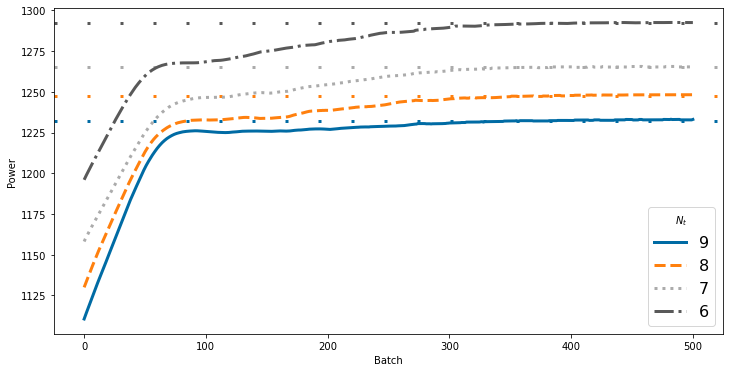

In [6]:
plt.style.use('tableau-colorblind10')                                                          
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.rcParams.update({'font.size': 20})
plt.rc('lines', linewidth=3.0)

linestyles = ['-', '--', ':', '-.']

markerstyles = ['+', 'x', '*', 'o']
marker_names = ["DC", "Opt.", "Lookup", "Baseline"]

plt.rcParams.update({'lines.markersize': 15})

ps_FLORIS_validation = [p_FLORIS_validation_9t, p_FLORIS_validation_8t, \
                        p_FLORIS_validation_7t, p_FLORIS_validation_6t]

for i in range(4):
    nturbs_active = 9-i
    plt.plot(np.array(np.array(powers_plot[i])/nturbs_active), label=str(nturbs_active), 
             color=colors[i], linestyle=linestyles[i], linewidth=3)
    plt.axhline(np.mean(ps_FLORIS_validation[i])/nturbs_active, color=colors[i], linestyle=(0, (1, 10)), linewidth=3)
    
plt.legend(title="$N_t$", prop={'size': 16})
plt.xlabel('Batch')
plt.ylabel('Power')
fig = plt.gcf()
fig.set_size_inches(12,6)
# plt.savefig('/Users/jani/Documents/research/windFarmControl/2023ACC/figures_resubmission/training.png', 
#              bbox_inches='tight')
plt.show()

# Loss averaged over the wind speeds in the validation set
# for each turbine status vector in the validation set, 
# labeled by the number of active turbines (6, 7, 8, or 9.)

### Testing plots

In [7]:
ws_plot =[3, 4, 5, 6, 7, 8, 9, 10, 11]
ws_test = torch.tensor(ws_plot[::-1])

In [8]:
ps_DC = []

for i in range(len(active_turbs_validation)):
    ws = ws_test
    wd = wd_validation.repeat(ws.shape[0])
    active_turbs = active_turbs_validation[i].repeat(ws.shape[0], 1)

    # generate mesh on turbine rotor
    x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
        mesh_y_rotated, mesh_z, inds_sorted = \
        floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)

    # sort active turbines
    active_turbs_sorted = torch.take_along_dim(
        active_turbs.unsqueeze(-1).unsqueeze(-1), inds_sorted, axis=1)

    # get control action
    scaled_u_sorted, _, u = get_control(model, ws, inds_sorted, ws_min, ws_max, \
        active_turbs=active_turbs)

    # calculate field on rotor mesh
    flow_field_u, yaw_angle = floris_pt.get_field_rotor(ws, scaled_u_sorted, \
        x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
        mesh_y_rotated, mesh_z, inds_sorted, active_turbs_sorted=active_turbs_sorted)

    # calculate turbine power
    p = floris_pt.get_power(flow_field_u, x_coord_rotated, yaw_angle, \
        active_turbs_sorted=active_turbs_sorted)

    farm_power = torch.sum(p, axis=1).detach().numpy()

    ps_DC.append(farm_power)
ps_DC.reverse()

ps_DC

[array([23187.121  , 17499.285  , 12761.611  ,  8978.018  ,  5990.439  ,
         3686.4578 ,  2002.2025 ,   857.5019 ,   161.18935], dtype=float32),
 array([26517.225  , 19997.746  , 14597.8545 , 10263.08   ,  6847.283  ,
         4205.325  ,  2278.4336 ,   969.3855 ,   178.09569], dtype=float32),
 array([29901.918  , 22545.672  , 16452.248  , 11570.33   ,  7714.094  ,
         4736.771  ,  2564.5513 ,  1088.2837 ,   195.83537], dtype=float32),
 array([33228.016  , 25063.41   , 18286.459  , 12871.6    ,  8571.662  ,
         5256.8223 ,  2842.2222 ,  1201.1707 ,   211.64836], dtype=float32)]

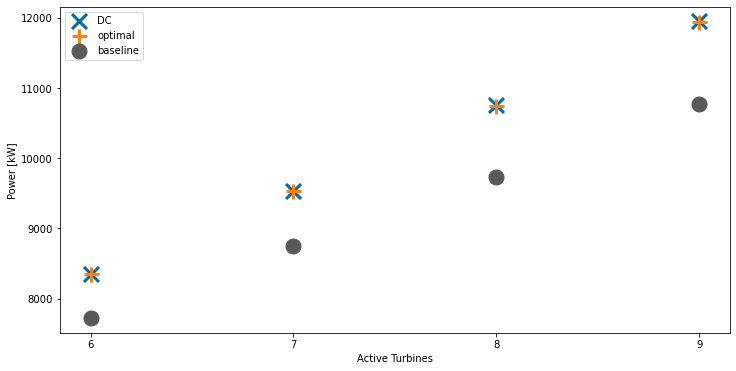

In [9]:
ps_FLORIS = [p_FLORIS_6t, p_FLORIS_7t, p_FLORIS_8t, p_FLORIS_9t]
ps_baseline = [p_baseline_6t, p_baseline_7t, p_baseline_8t, p_baseline_9t]

nturbs_active = [6, 7, 8, 9]
plt.scatter(nturbs_active, [np.mean(p) for p in ps_DC], color=colors[0], \
            marker='x', label="DC")
plt.scatter(nturbs_active, [np.mean(p) for p in ps_FLORIS], color=colors[1], \
            marker='+', label="optimal")
plt.scatter(nturbs_active, [np.mean(p) for p in ps_baseline], \
            marker='o', color=colors[3], label="baseline")
plt.xlabel("Active Turbines")
plt.ylabel("Power [kW]")
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12,6)
ax=plt.gca()
plt.xticks(ticks=nturbs_active, labels=[str(nt) for nt in nturbs_active])
# plt.savefig('/Users/jani/Documents/research/windFarmControl/2023ACC/figures_resubmission/testing_Nt.png', 
#              bbox_inches='tight')
plt.show()

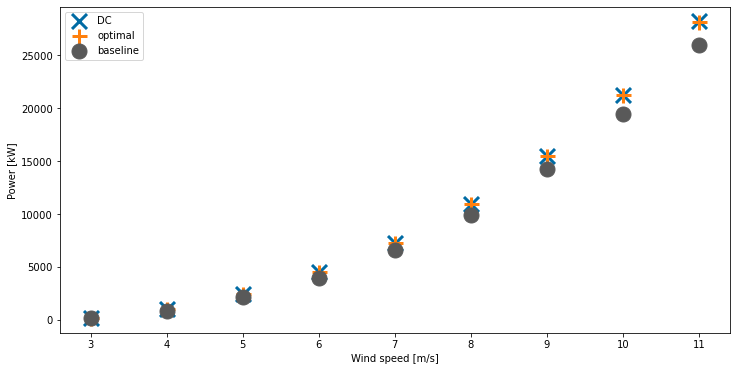

In [10]:
def t_to_ws(ps_t):
    ps_ws = np.zeros(len(ws_plot))
    for ps in ps_t:
        for i in range(len(ps)):
            ps_ws[i] += ps[i]
    ps_ws /= len(ps_t)
    return np.flip(ps_ws)

ps_DC_ws = t_to_ws(ps_DC)
ps_FLORIS_ws = t_to_ws(ps_FLORIS)
ps_baseline_ws = t_to_ws(ps_baseline)


plt.scatter(ws_plot, ps_DC_ws, color=colors[0], marker='x', label="DC")
plt.scatter(ws_plot, ps_FLORIS_ws, color=colors[1], marker='+', label="optimal")
plt.scatter(ws_plot, ps_baseline_ws, marker='o', color=colors[3], label="baseline")
plt.xlabel("Wind speed [m/s]")
plt.ylabel("Power [kW]")
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.xticks(ticks=ws_plot, labels=[str(ws) for ws in ws_plot])
# plt.savefig('/Users/jani/Documents/research/windFarmControl/2023ACC/figures_resubmission/testing_u.png', 
#              bbox_inches='tight')
plt.show()

### yaw plots

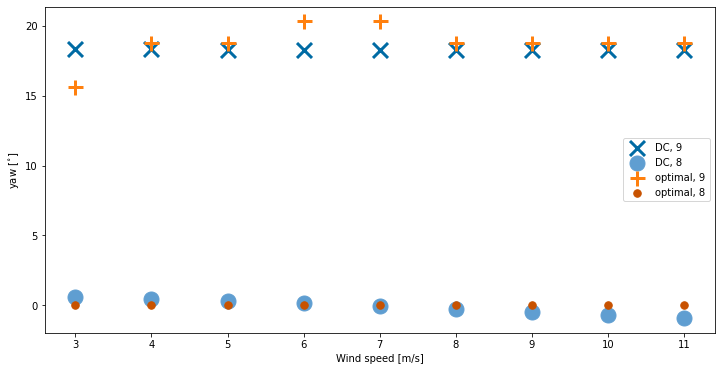

In [11]:
t1_9t_FLORIS = [yaw_9t_ws[7] for yaw_9t_ws in yaw_9t]
t1_8t_FLORIS = [yaw_8t_ws[7] for yaw_8t_ws in yaw_8t]
t1_9t_FLORIS.reverse()
t1_8t_FLORIS.reverse()

ws = torch.tensor(ws_plot)
wd = wd_validation.repeat(ws.shape[0])
active_turbs = active_turbs_validation[0].repeat(ws.shape[0], 1)
x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted = \
    floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)
_, scaled_u, _ = get_control(model, ws, inds_sorted, ws_min, ws_max, \
    active_turbs=active_turbs)
t1_9t_DC = scaled_u[:,7,0,0].squeeze().detach().numpy()

active_turbs = active_turbs_validation[1].repeat(ws.shape[0], 1)
x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted = \
    floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)
_, scaled_u, _ = get_control(model, ws, inds_sorted, ws_min, ws_max, \
    active_turbs=active_turbs)
t1_8t_DC = scaled_u[:,7,0,0].squeeze().detach().numpy()
    
plt.scatter(ws_plot, t1_9t_DC, color=colors[0], marker='x', label="DC, 9")
plt.scatter(ws_plot, t1_8t_DC, color=colors[4], marker='o', label="DC, 8")
plt.scatter(ws_plot, t1_9t_FLORIS, color=colors[1], marker='+', label="optimal, 9")
plt.scatter(ws_plot, t1_8t_FLORIS, color=colors[5], marker='.', label="optimal, 8")
plt.xlabel("Wind speed [m/s]")
plt.ylabel(r'yaw $[^{\circ}]$')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.xticks(ticks=ws_plot, labels=[str(ws) for ws in ws_plot])
# plt.savefig('/Users/jani/Documents/research/windFarmControl/2023ACC/figures_resubmission/yaw_t1.png', 
#              bbox_inches='tight')
plt.show()

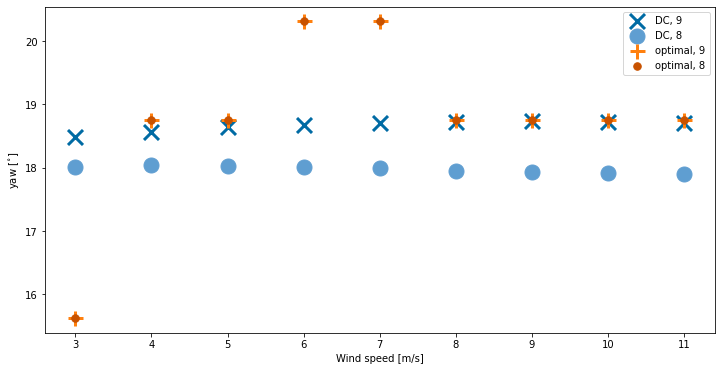

In [12]:
t2_9t_FLORIS = [yaw_9t_ws[4] for yaw_9t_ws in yaw_9t]
t2_8t_FLORIS = [yaw_8t_ws[4] for yaw_8t_ws in yaw_8t]
t2_9t_FLORIS.reverse()
t2_8t_FLORIS.reverse()

ws = torch.tensor(ws_plot)
wd = wd_validation.repeat(ws.shape[0])
active_turbs = active_turbs_validation[0].repeat(ws.shape[0], 1)
x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted = \
    floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)
_, scaled_u, _ = get_control(model, ws, inds_sorted, ws_min, ws_max, \
    active_turbs=active_turbs)
t2_9t_DC = scaled_u[:,4,0,0].squeeze().detach().numpy()

active_turbs = active_turbs_validation[1].repeat(ws.shape[0], 1)
x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted = \
    floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)
_, scaled_u, _ = get_control(model, ws, inds_sorted, ws_min, ws_max, \
    active_turbs=active_turbs)
t2_8t_DC = scaled_u[:,4,0,0].squeeze().detach().numpy()
    
plt.scatter(ws_plot, t2_9t_DC, color=colors[0], marker='x', label="DC, 9")
plt.scatter(ws_plot, t2_8t_DC, color=colors[4], marker='o', label="DC, 8")
plt.scatter(ws_plot, t2_9t_FLORIS, color=colors[1], marker='+', label="optimal, 9")
plt.scatter(ws_plot, t2_8t_FLORIS, color=colors[5], marker='.', label="optimal, 8")
plt.xlabel("Wind speed [m/s]")
plt.ylabel(r'yaw $[^{\circ}]$')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.xticks(ticks=ws_plot, labels=[str(ws) for ws in ws_plot])
# plt.savefig('/Users/jani/Documents/research/windFarmControl/2023ACC/figures_resubmission/yaw_t2.png', 
#              bbox_inches='tight')
plt.show()

## Testing numerical results

In [13]:
# training time
runtime

71.2069947719574

In [14]:
# percent error in power from DC vs. FLORIS:
# mean, max (DC better than FLORIS), min (FLORIS better than DC)
err = (np.array(ps_DC) - np.array(ps_FLORIS))/(np.array(ps_FLORIS))*100.
np.round(np.mean(err), 2), np.round(np.max(err), 2), np.round(np.min(err), 2)

(-0.05, 0.13, -0.72)

In [15]:
# diff. in yaw from FLORIS vs. DC: mean, max
yaw_FLORIS = [yaw_9t, yaw_8t, yaw_7t, yaw_6t]
yaws_mean = 0.
yaws_max = 0.
N = active_turbs_validation.shape[0]
ws = ws_test
for i in range(N):
    wd = wd_validation.repeat(ws.shape[0])
    active_turbs = active_turbs_validation[i].repeat(ws.shape[0], 1)
    x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
        mesh_y_rotated, mesh_z, inds_sorted = \
        floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)
    _, scaled_u, _ = get_control(model, ws, inds_sorted, ws_min, ws_max, \
        active_turbs=active_turbs)
    yaw_DC_i = scaled_u.detach().numpy().squeeze()
    if i > 0:
        yaw_DC_i = yaw_DC_i[:,:-i]

    yaw_FLORIS_i = yaw_FLORIS[i]
    
    yaw_diff = np.abs(yaw_FLORIS_i - yaw_DC_i)
    yaw_mean = np.mean(yaw_diff)
    yaw_max = np.max(yaw_diff)
    yaws_mean += yaw_mean
    yaws_max = np.max([yaws_max, yaw_max])
yaws_mean /= N
np.round(yaws_mean, 2), np.round(yaws_max, 2)

(0.78, 4.05)